In [15]:
import xarray as xr

working_folder = "/home/imperatoren/work/VIIRS_S2_comparison/viirsnow/output_folder/version_5_complete/"
period = slice('2023-12-01', '2023-12-31')
fore = 'no_forest'
nasa_scatter = xr.open_dataset(
        f"{working_folder}/analyses/scatter/scatter_WY_2023_2024_nasa_l3_vs_s2_theia.nc",
        decode_cf=True,
    ).sel(time=period, forest_mask_bins=[fore])
s2_fsc = xr.open_dataset(
        f"{working_folder}/time_series/WY_2023_2024_s2_theia.nc",
        decode_cf=True,
    ).sel(time=period)
nasa= xr.open_dataset(
        f"{working_folder}/time_series/WY_2023_2024_nasa_l3.nc",
        decode_cf=True,
    ).sel(time=period).drop_vars('snow_cover_fraction')
# mf_fsc_old = xr.open_dataset(
#         f"{working_folder}/time_series/WY_2023_2024_meteofrance_synopsis.nc",
#         decode_cf=True,
#     ).sel(time=period)

[]

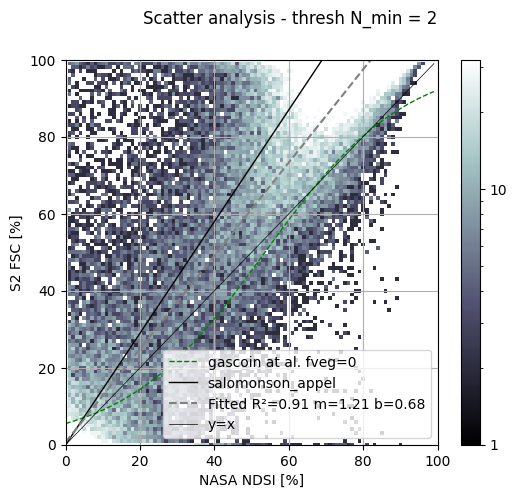

In [16]:
from postprocess.scatter_plot import fit_regression
from reductions.completeness import MeteoFranceSnowCoverProductCompleteness
from matplotlib import pyplot as plt

from fractional_snow_cover import gascoin, salomonson_appel
from postprocess.scatter_plot import fancy_scatter_plot


fig, ax = plt.subplots( figsize=(6 , 5))
n_min = 2
fig.suptitle(f"Scatter analysis - thresh N_min = {n_min}")

reduced_v = (
    nasa_scatter.sel(
        ref_bins=slice(0, 99),
        test_bins=slice(0, 99),
    )
    .sum(dim=("forest_mask_bins", "time", "aspect_bins", "sub_roi_bins"))
    .data_vars["n_occurrences"]
)
xax = reduced_v.test_bins.values
fit_g = gascoin(xax * 0.01, f_veg=0) * 100
ax.plot(xax, fit_g, "g--", linewidth=1, label="gascoin at al. fveg=0")
ax.plot(xax, salomonson_appel(xax), "k", linewidth=1, label="salomonson_appel")
scatter_plot = fancy_scatter_plot(
    data_to_plt=reduced_v.rename({"ref_bins": "y", "test_bins": "x"}),
    ax=ax,
    figure=fig,
    low_threshold=n_min,
    smoothing_window_size=0,
)
# ax.set_title(PRODUCT_PLOT_NAMES[k])
ax.set_ylabel("S2 FSC [%]")
ax.set_xlabel(f"NASA NDSI [%]")
ax.plot()



In [17]:
import numpy as np
from reductions.completeness import SnowCoverProductCompleteness
from logger_setup import default_logger as logger
import numpy.ma as ma
import numpy.typing as npt

data_for_fit = nasa_scatter.data_vars['n_occurrences'].rename({"ref_bins": "y", "test_bins": "x"}).sum(dim=("forest_mask_bins", "time", "aspect_bins", "sub_roi_bins")).transpose("y", "x")
coeff_slope, intercept, score = fit_regression(data_for_fit)
print(coeff_slope, intercept)

def salomonson_appel(ndsi):
    return 1.45 * ndsi - 0.01



def new_linear(ndsi, coeff, intercept):
    # print(coeff, intercept)
    return coeff * ndsi + intercept

def ndsi_snow_cover_to_fraction(
    ndsi_snow_cover_product: npt.NDArray,
    snow_cover_ndsi_threshold: int = 10,
    max_ndsi: int = 100,
    method: str = "salomonson_appel",
) -> npt.NDArray:
    snow_mask = (ndsi_snow_cover_product >= snow_cover_ndsi_threshold) & (ndsi_snow_cover_product <= max_ndsi)
    masked_ndsi_snow_cover = ma.masked_array(ndsi_snow_cover_product, mask=(1 - snow_mask)) / max_ndsi
    if method == "salomonson_appel":
        snow_cover_fraction = salomonson_appel(masked_ndsi_snow_cover)
        snow_cover_fraction = np.clip(snow_cover_fraction, a_max=1, a_min=0)
    elif method == "new":
        snow_cover_fraction = new_linear(masked_ndsi_snow_cover, coeff=coeff_slope, intercept=intercept/100)
        snow_cover_fraction = np.clip(snow_cover_fraction, a_max=1, a_min=0)
    else:
        raise NotImplementedError(f"Fractional snow cover method {method} not known.")
    out_fractional_snow_cover = (snow_cover_fraction.data * max_ndsi).astype(np.uint8)
    out_fractional_snow_cover = np.where(snow_mask == 1, out_fractional_snow_cover, ndsi_snow_cover_product)

    return out_fractional_snow_cover



def nasa_ndsi_snow_cover_to_fraction(meteofrance_ndsi_snow_cover_product: npt.NDArray) -> npt.NDArray:
    return ndsi_snow_cover_to_fraction(meteofrance_ndsi_snow_cover_product, snow_cover_ndsi_threshold=10, max_ndsi=100, method="new")

def convert_to_fsc(ndsi_data_array: xr.DataArray) -> xr.DataArray:
    logger.info(f"Day {ndsi_data_array.coords['time'].values[0]}")
    ndsi_data_array[:] = nasa_ndsi_snow_cover_to_fraction(ndsi_data_array.values)
    return ndsi_data_array

nasa_fsc_new = nasa.data_vars['NDSI_Snow_Cover'].groupby('time').map(convert_to_fsc)
nasa_fsc_new=nasa.drop_vars('NDSI_Snow_Cover').assign({'snow_cover_fraction': nasa_fsc_new})

INFO:logger:Day 2023-12-01T00:00:00.000000000


1.186841752080264 0.9713145948498223


/tmp/ipykernel_32680/2153561981.py:36: RuntimeWarning: invalid value encountered in cast
  out_fractional_snow_cover = (snow_cover_fraction.data * max_ndsi).astype(np.uint8)
INFO:logger:Day 2023-12-02T00:00:00.000000000
INFO:logger:Day 2023-12-03T00:00:00.000000000
INFO:logger:Day 2023-12-04T00:00:00.000000000
INFO:logger:Day 2023-12-05T00:00:00.000000000
INFO:logger:Day 2023-12-06T00:00:00.000000000
INFO:logger:Day 2023-12-07T00:00:00.000000000
INFO:logger:Day 2023-12-08T00:00:00.000000000
INFO:logger:Day 2023-12-09T00:00:00.000000000
INFO:logger:Day 2023-12-10T00:00:00.000000000
INFO:logger:Day 2023-12-11T00:00:00.000000000
INFO:logger:Day 2023-12-12T00:00:00.000000000
INFO:logger:Day 2023-12-13T00:00:00.000000000
INFO:logger:Day 2023-12-14T00:00:00.000000000
INFO:logger:Day 2023-12-15T00:00:00.000000000
INFO:logger:Day 2023-12-16T00:00:00.000000000
INFO:logger:Day 2023-12-17T00:00:00.000000000
INFO:logger:Day 2023-12-18T00:00:00.000000000
INFO:logger:Day 2023-12-19T00:00:00.00000000

In [18]:
from reductions.statistics_base import EvaluationConfig
from reductions.uncertainty import UncertaintyMeteoFrance, UncertaintyNASA

old_metrics = xr.open_dataset(f"{working_folder}/analyses/uncertainty/uncertainty_WY_2023_2024_nasa_l3_vs_s2_theia.nc").sel(time=period)

In [19]:
from reductions.statistics_base import EvaluationConfig
from reductions.uncertainty import UncertaintyNASA
config_eval = EvaluationConfig(
    ref_fsc_step=99,
    sensor_zenith_analysis=False,
    forest_mask_path="/home/imperatoren/work/VIIRS_S2_comparison/data/auxiliary/forest_mask/corine_2006_forest_mask_utm.tif",
    sub_roi_mask_path=None,
    slope_map_path=None,
    aspect_map_path=None,
    dem_path=None,
)


metrics_calculator = UncertaintyNASA()
new_metrics = metrics_calculator.uncertainty_analysis(test_time_series=nasa_fsc_new, ref_time_series=s2_fsc, config=config_eval)

INFO:logger:Processing time of the year 2023-12-02
INFO:logger:Processing time of the year 2023-12-03
INFO:logger:No intersection found on this day. Returning a zeros array.
INFO:logger:Processing time of the year 2023-12-04
INFO:logger:Processing time of the year 2023-12-05
INFO:logger:No intersection found on this day. Returning a zeros array.
INFO:logger:Processing time of the year 2023-12-06
INFO:logger:Processing time of the year 2023-12-07
INFO:logger:Processing time of the year 2023-12-09
INFO:logger:Processing time of the year 2023-12-10
INFO:logger:Processing time of the year 2023-12-13
INFO:logger:Processing time of the year 2023-12-14
INFO:logger:Processing time of the year 2023-12-15
INFO:logger:Processing time of the year 2023-12-16
INFO:logger:Processing time of the year 2023-12-17
INFO:logger:Processing time of the year 2023-12-18
INFO:logger:Processing time of the year 2023-12-19
INFO:logger:Processing time of the year 2023-12-20
INFO:logger:Processing time of the year 

In [20]:
import pandas as pd
from postprocess.error_distribution import fancy_table_error_distribution, histograms_to_biais_rmse
from products.plot_settings import PRODUCT_PLOT_NAMES



reduced_datasets = []
for dataset in [old_metrics.sel(forest_mask_bins=fore), xr.Dataset({new_metrics.name:new_metrics.sel(forest_mask_bins=fore)})]:
    reduced_datasets.append(histograms_to_biais_rmse(dataset))
concatenated = xr.concat(reduced_datasets, pd.Index(['old', 'new'], name="product"), coords="minimal")
reduced_df = concatenated.to_dataframe().reset_index('product')
fancy_table_error_distribution(reduced_df)

product,biais,rmse,unbiaised_rmse,forest_mask_bins
old,0.23,9.29,9.29,no_forest
new,-1.31,9.42,9.32,no_forest
